# Imports

In [1]:
# To get environment variables
import os

from dotenv import load_dotenv
load_dotenv()

from rich.pretty import pprint

# Make the display a bit wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


# Our chat model
from langchain.chat_models.openai import ChatOpenAI

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import HumanMessage

# Initialise langchain llms gpt-4o & claude-3.5-sonnet

In [2]:
llm_gpt_4o = ChatOpenAI(
                  base_url="https://api.naga.ac/v1/",
                  temperature=0,
                  openai_api_key=os.getenv('NAGA_API_KEY', 'YourAPIKeyIfNotSet'),
                  model_name="gpt-4o",
                  request_timeout = 180
                 )

llm_35_sonnet = ChatOpenAI(
                  base_url="https://api.naga.ac/v1/",
                  temperature=0,
                  openai_api_key=os.getenv('NAGA_API_KEY', 'YourAPIKeyIfNotSet'),
                  model_name="claude-3.5-sonnet-20240620",
                  request_timeout = 180
                 )

/Users/chris/PycharmProjects/Oanda/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


# Set up chain workflow for S&R bands prediction given candlestick data

## Method 1: Give the model the candlestick data in JSON format and let it predict the S&R bands

In [30]:
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional

def extract_json_str(ai_message) -> str:
    message = ai_message.content
    # Find the first occurrence of '{' and the last occurrence of '}'
    start = message.find('{')
    end = message.rfind('}') + 1  # '+ 1' to include the '}' in the slice

    # Extract the substring between these indices
    json_str = message[start:end]

    return json_str

class BandsData(BaseModel):
    """Support and resistance bands price data range"""
    support_high: float = Field(description="upper price limit of support band")
    support_low: float = Field(description="lower price limit of support band")
    resistance_high: float = Field(description="upper price limit of resistance band")
    resistance_low: float = Field(description="lower price limit of resistance band")


output_parser = JsonOutputParser(pydantic_object=BandsData)

def predict_snr_from_json_data(candlestick_json_path: str) -> BandsData:
    with open(candlestick_json_path, 'r') as f:
        candlestick_data = f.read()

# 5. Candlestick Open and Close data should be weighted higher compared to High and Low data when determining levels.
    
    template = """
    You are an expert technical analyst in the forex market. Follow these key
    principles when identifying support and resistance levels:

        ### Methods to Identify Levels
        1. **Historical Price Points**: Look for historical price points where the
      price has repeatedly halted or reversed. These points often become future
      support or resistance levels.
        2. **Number of Touches**: The more times a price tests a support or
      resistance level, the stronger that level is considered to be.
        3. **Volume Analysis**: High trading volume at certain price levels can
      strengthen these levels, as it indicates significant interest and activity.
        4. High and Low price levels identified should not be in regular intervals (e.g. 50 pips
      between the High and Low of Support/Resistance).
        ### Drawing Support and Resistance Lines
        - Use horizontal lines to connect price points where the price has
      previously reversed or paused.
        ### Task
        Analyse the following OHLC candlestick data in JSON of a forex currency pair and
      determine the optimal support and resistance bands.

    Wrap the output in `json` tags\n{format_instructions}

    Here is the candlestick data:
    {candlestick_data}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["candlestick_data"],
        partial_variables={"format_instructions": output_parser.get_format_instructions()},
    )

    chain = prompt | llm_gpt_4o | extract_json_str | output_parser
    extracted_output = chain.invoke({"candlestick_data": candlestick_data})
    return extracted_output

## Method 2: Give the model the candlestick data in IMAGE format and let it predict the S&R bands

In [31]:
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
import base64

def extract_json_str(ai_message) -> str:
    message = ai_message.content
    # Find the first occurrence of '{' and the last occurrence of '}'
    start = message.find('{')
    end = message.rfind('}') + 1  # '+ 1' to include the '}' in the slice

    # Extract the substring between these indices
    json_str = message[start:end]

    return json_str

class BandsData(BaseModel):
    """Support and resistance bands price data range"""
    support_high: float = Field(description="upper price limit of support band")
    support_low: float = Field(description="lower price limit of support band")
    resistance_high: float = Field(description="upper price limit of resistance band")
    resistance_low: float = Field(description="lower price limit of resistance band")


output_parser = JsonOutputParser(pydantic_object=BandsData)

def predict_snr_from_image(image_path: str) -> BandsData:
    with open(image_path, "rb") as image_file:
        image_data = base64.b64encode(image_file.read()).decode("utf-8")

    template = """
    You are an expert technical analyst in the forex market. Follow these key
    principles when identifying support and resistance levels:

        ### Methods to Identify Levels
        1. **Historical Price Points**: Look for historical price points where the
      price has repeatedly halted or reversed. These points often become future
      support or resistance levels.
        2. **Number of Touches**: The more times a price tests a support or
      resistance level, the stronger that level is considered to be.
        3. **Volume Analysis**: High trading volume at certain price levels can
      strengthen these levels, as it indicates significant interest and activity.

        ### Drawing Support and Resistance Lines
        - Use horizontal lines to connect price points where the price has
      previously reversed or paused.
        - For dynamic levels, trendlines can be drawn diagonally to represent
      support in uptrends and resistance in downtrends.

        ### Task
        Analyse the following candlestick chart of a forex currency pair and
      determine the optimal support and resistance bands. Provide your output in
      JSON format.

    Wrap the output in `json` tags\n{format_instructions}
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant"),
        HumanMessage(
        content=[
            {"type": "text", "text": template.format(format_instructions=output_parser.get_format_instructions())},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image_data}"}, # dict for gpt-4o
            }
        ],
    )
    ])

    chain = prompt | llm_gpt_4o | extract_json_str | output_parser
    extracted_output = chain.invoke({"image_data": image_data})
    return extracted_output
# pred = predict_snr_from_image("candlestick_chart.png")

# Set up plotting functions for charts

In [5]:
import pandas as pd
import mplfinance as mpf
import json

def plot_candlestick(data: dict, output_file=None):
    # Parse the data into a DataFrame
    df = pd.DataFrame([{
        'Date': item['time'],
        'Open': float(item['mid']['o']),
        'High': float(item['mid']['h']),
        'Low': float(item['mid']['l']),
        'Close': float(item['mid']['c']),
        'Volume': item['volume']
    } for item in data])

    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Plot the candlestick chart and save it to an image file if specified
    if output_file:
        mpf.plot(df, type='candle', volume=True, style='charles', savefig=output_file)
    else:
        mpf.plot(df, type='candle', volume=True, style='charles')

# with open('candle_data.json', 'r') as file:
#     data = json.load(file)

# # Plot the candlestick chart and save it as an image
# plot_candlestick(data, 'candlestick_chart.png')

In [6]:
import pandas as pd
import mplfinance as mpf
import json

def plot_candlestick_with_bands(candlestick_json_path: str, bands_data: dict, title: str = ""):
	with open(candlestick_json_path, 'r') as file:
		candlestick_data = json.load(file)

	# Parse the candlestick data into a DataFrame
	df = pd.DataFrame([{
		'Date': item['time'],
		'Open': float(item['mid']['o']),
		'High': float(item['mid']['h']),
		'Low': float(item['mid']['l']),
		'Close': float(item['mid']['c']),
		'Volume': item['volume']
	} for item in candlestick_data])

	# Convert the 'Date' column to datetime
	df['Date'] = pd.to_datetime(df['Date'])
	df.set_index('Date', inplace=True)

	# Initialize the list for additional plots
	ap0 = []

	# Conditionally add support and resistance bands if they exist
	if 'support_high' in bands_data:
		support_high = [bands_data.get('support_high')] * len(df)
		ap0.append(mpf.make_addplot(support_high, color='green', linestyle='--'))
	if 'support_low' in bands_data:
		support_low = [bands_data.get('support_low')] * len(df)
		ap0.append(mpf.make_addplot(support_low, color='green', linestyle='--'))
	if 'resistance_high' in bands_data:
		resistance_high = [bands_data.get('resistance_high')] * len(df)
		ap0.append(mpf.make_addplot(resistance_high, color='red', linestyle='--'))
	if 'resistance_low' in bands_data:
		resistance_low = [bands_data.get('resistance_low')] * len(df)
		ap0.append(mpf.make_addplot(resistance_low, color='red', linestyle='--'))

	# Plot the candlestick chart with the bands
	mpf.plot(df, type='candle', volume=True, style='charles', addplot=ap0, title=title)


# bands_data = extracted_output

# # Plot the candlestick chart with the bands
# plot_candlestick_with_bands('candle_data.json', bands_data)

In [7]:
import pandas as pd
import plotly.graph_objects as go
import json

def plot_plotly_candlestick_with_bands(candlestick_data, bands_data):
    # Parse the candlestick data into a DataFrame
    df = pd.DataFrame([{
        'Date': item['time'],
        'Open': float(item['mid']['o']),
        'High': float(item['mid']['h']),
        'Low': float(item['mid']['l']),
        'Close': float(item['mid']['c']),
        'Volume': item['volume']
    } for item in candlestick_data])

    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Create the candlestick figure
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candlesticks'
    )])

    # Conditionally add the support and resistance bands
    if 'support_high' in bands_data:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=[bands_data['support_high']] * len(df),
            mode='lines',
            line=dict(color='green', dash='dash'),
            name='Support High'
        ))

    if 'support_low' in bands_data:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=[bands_data['support_low']] * len(df),
            mode='lines',
            line=dict(color='green', dash='dash'),
            name='Support Low'
        ))

    if 'resistance_high' in bands_data:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=[bands_data['resistance_high']] * len(df),
            mode='lines',
            line=dict(color='red', dash='dash'),
            name='Resistance High'
        ))

    if 'resistance_low' in bands_data:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=[bands_data['resistance_low']] * len(df),
            mode='lines',
            line=dict(color='red', dash='dash'),
            name='Resistance Low'
        ))

    # Update layout
    fig.update_layout(
        title='Candlestick Chart with Support and Resistance Bands',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False
    )

    fig.show()

    # # Save the plot to an HTML file
    # fig.write_html("candlestick_with_bands.html")

# # Plot the candlestick chart with the bands
# with open('candle_data.json', 'r') as file:
#     candlestick_data = json.load(file)


# plot_plotly_candlestick_with_bands(candlestick_data, bands_data)

# Get candlestick data

In [8]:
import candle
import json
from datetime import datetime, timedelta

def compute_start_date(end_date: str, days_apart: int) -> str:
    """returns the start date in the eg string format '2023-06-17' given the end date and days apart

    Args:
        end_date (string): end date in the format '%Y-%m-%d' like '2023-07-17'
        days_apart (int): number of days apart from the end date

    Returns:
        start_date: start date in the format '%Y-%m-%d' like '2023-06-17'
    """
    start_date = end_date - timedelta(days=days_apart)
    return start_date.strftime('%Y-%m-%d')



end_date = '2023-07-17'
start_date = compute_start_date(datetime.strptime(end_date, '%Y-%m-%d'), 30)
timeframe = 'H1' # 1 Hour CandleStick
instrument = 'EUR_JPY'

candle_data = candle.fetch_candle_data(start_date, end_date, timeframe, instrument) # this method auto saves the data to a json file 'candle_data.json'
# print(candle_data)

candle_data = json.loads(candle_data)

# Get the updated chart image
plot_candlestick(candle_data, 'candlestick_chart.png')


# Run the workflows

In [9]:
with open('candle_data.json', 'r') as file:
    candlestick_data = file.read()
    candle_json = json.loads(candlestick_data)

## Method 1: S&R bands prediction using JSON data

In [10]:
bands_data = predict_snr_from_json_data("candle_data.json")
bands_data

{'support_high': 154.5,
 'support_low': 154.0,
 'resistance_high': 156.0,
 'resistance_low': 155.5}

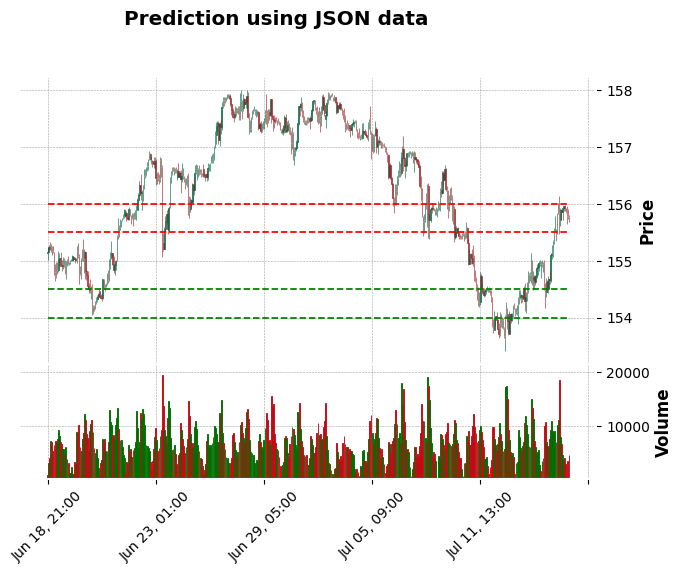

In [11]:
plot_candlestick_with_bands('candle_data.json', bands_data, title='Prediction using JSON data')

## Method 2: S&R bands prediction using IMAGE data
Note as of this moment, claude-3.5-sonnet on naga ai does not support multimodal image uploads, only gpt-4o does.

In [12]:
bands_data = predict_snr_from_image("candlestick_chart.png")
bands_data

{'support_high': 154.5,
 'support_low': 154.0,
 'resistance_high': 157.5,
 'resistance_low': 157.0}

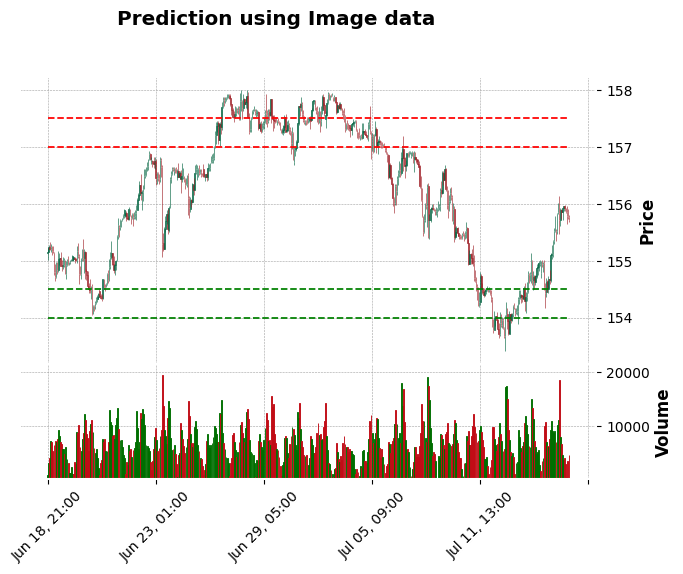

In [13]:
plot_candlestick_with_bands('candle_data.json', bands_data, title='Prediction using Image data')

# Set up functions for varying end_date input samples

/Users/chris/PycharmProjects/Oanda/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
/Users/chris/PycharmProjects/Oanda/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the nu

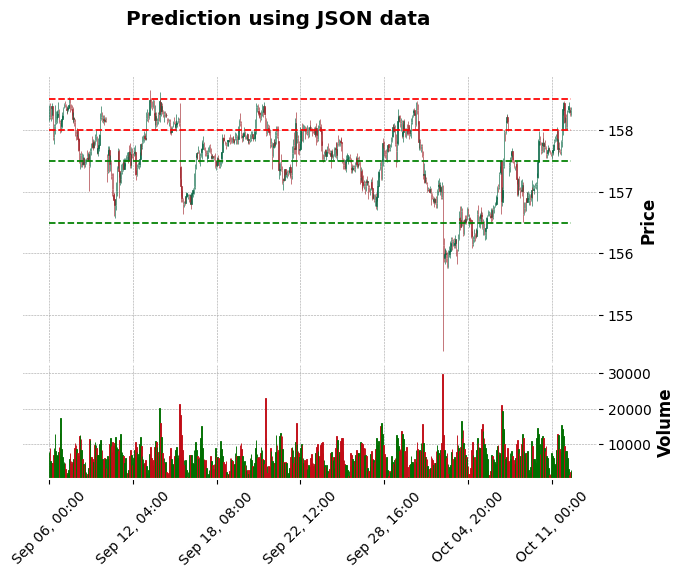

{'support_high': 157.5, 'support_low': 156.5, 'resistance_high': 158.5, 'resistance_low': 158.0}


In [32]:
def run_single_sample(end_date:str):
    start_date = compute_start_date(datetime.strptime(end_date, '%Y-%m-%d'), 36)
    timeframe = 'H1' # 1 Hour CandleStick
    instrument = 'EUR_JPY'

    candle_data = candle.fetch_candle_data(start_date, end_date, timeframe, instrument) # this method auto saves the data to a json file 'candle_data.json'
    candle_data = json.loads(candle_data)

    # Get the updated chart image
    plot_candlestick(candle_data, 'candlestick_chart.png')

    try:
        bands_data = predict_snr_from_json_data("candle_data.json")
        plot_candlestick_with_bands('candle_data.json', bands_data, title='Prediction using JSON data')
        print(bands_data)
    except Exception as e:
        print(f"Failed to predict using JSON data: {e}")

    # try:
    #     bands_data = predict_snr_from_image("candlestick_chart.png")
    #     plot_candlestick_with_bands('candle_data.json', bands_data, title='Prediction using Image data')
    #     print(bands_data)
    # except Exception as e:
    #     print(f"Failed to predict using Image data: {e}")
    #     
    # try:
    #     bands_data = predict_snr_from_image("tradingview_chart.png")
    #     plot_candlestick_with_bands('candle_data.json', bands_data, title='Prediction using Tradingview Image data')
    #     print(bands_data)
    # except Exception as e:
    #     print(f"Failed to predict using Tradingview Image data: {e}")

run_single_sample('2023-10-12')

# Main Loop Test
Provide a list of 5 sample end_dates to test the model's prediction accuracy.  
The main loop will compute the start date to be 30 days before the end_date.  
The main loop will run the model on each of the 5 sample date ranges and plot the results.  
A prediction of S&R bands will be made using JSON data and IMAGE data.  
We can compare and evaluate which method is more accurate.  

In [15]:
end_date_samples = [
  "2007-08-02",
  "2015-11-13",
  "2009-02-23",
  "2024-03-17",
  "2019-07-02"
]

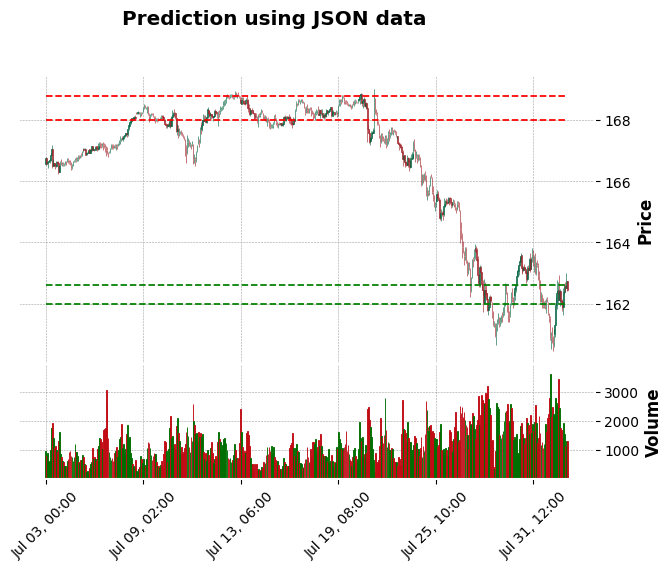

{'support_high': 162.6, 'support_low': 162.0, 'resistance_high': 168.8, 'resistance_low': 168.0}


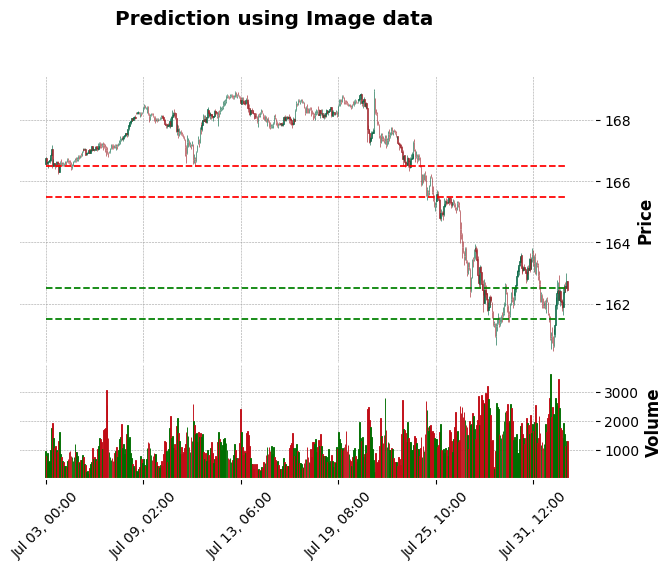

{'support_high': 162.5, 'support_low': 161.5, 'resistance_high': 166.5, 'resistance_low': 165.5}


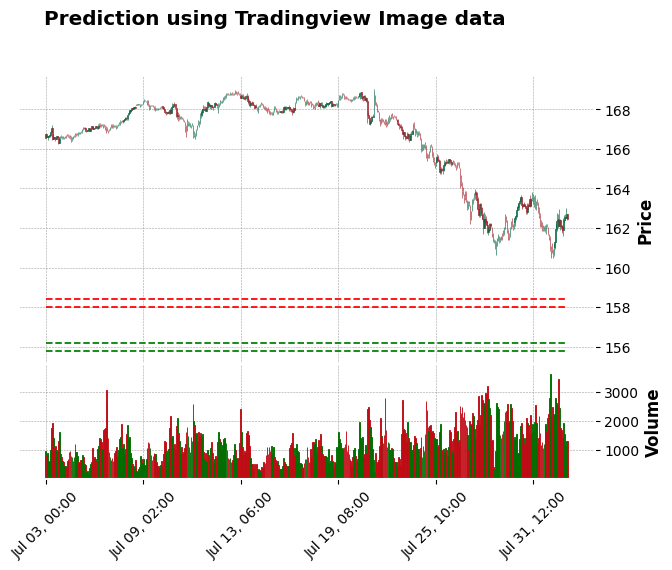

{'support_high': 156.2, 'support_low': 155.8, 'resistance_high': 158.4, 'resistance_low': 158.0}


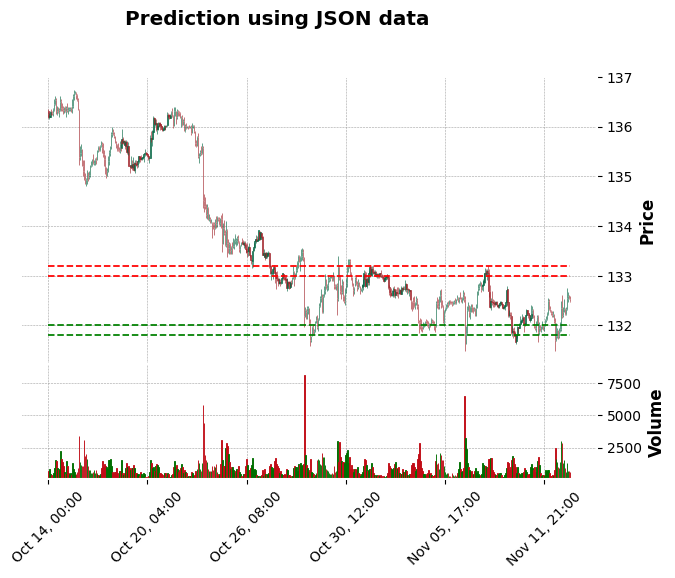

{'support_high': 132.0, 'support_low': 131.8, 'resistance_high': 133.2, 'resistance_low': 133.0}


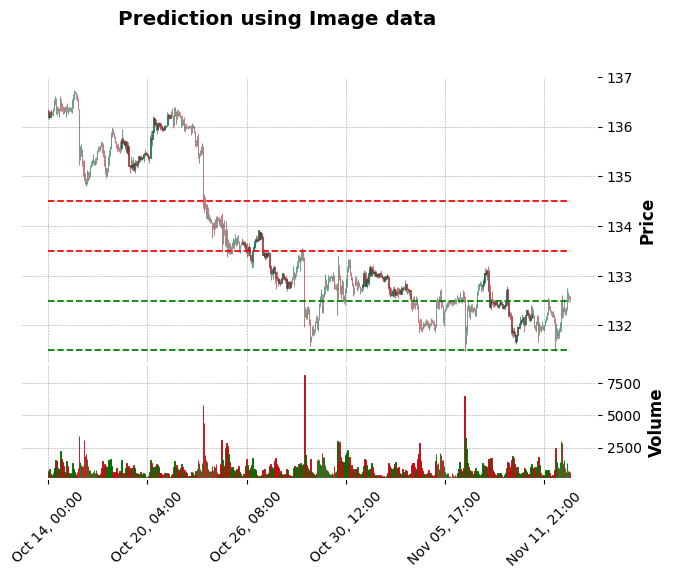

{'support_high': 132.5, 'support_low': 131.5, 'resistance_high': 134.5, 'resistance_low': 133.5}


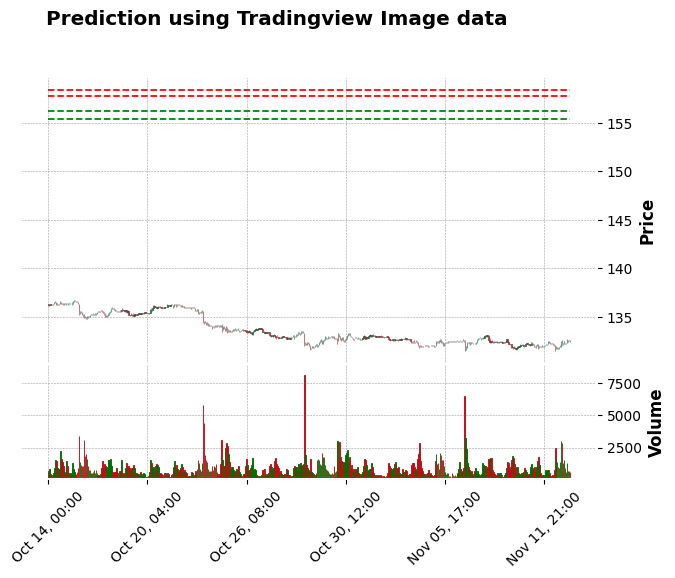

{'support_high': 156.2, 'support_low': 155.4, 'resistance_high': 158.4, 'resistance_low': 157.8}


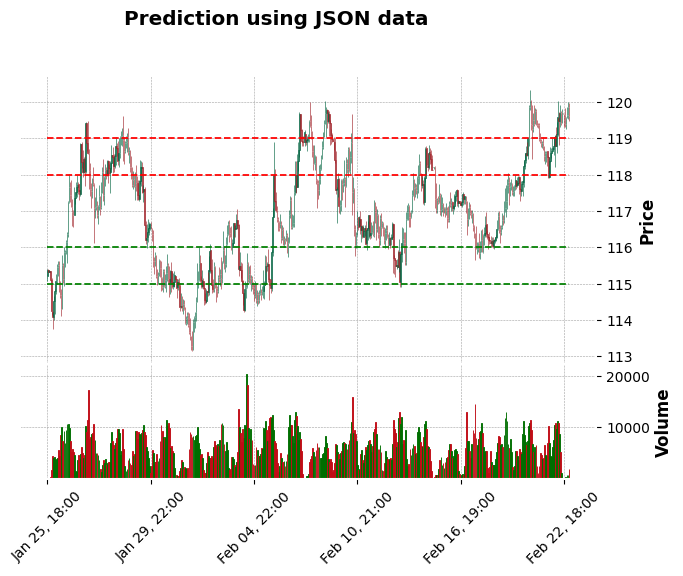

{'support_high': 116.0, 'support_low': 115.0, 'resistance_high': 119.0, 'resistance_low': 118.0}


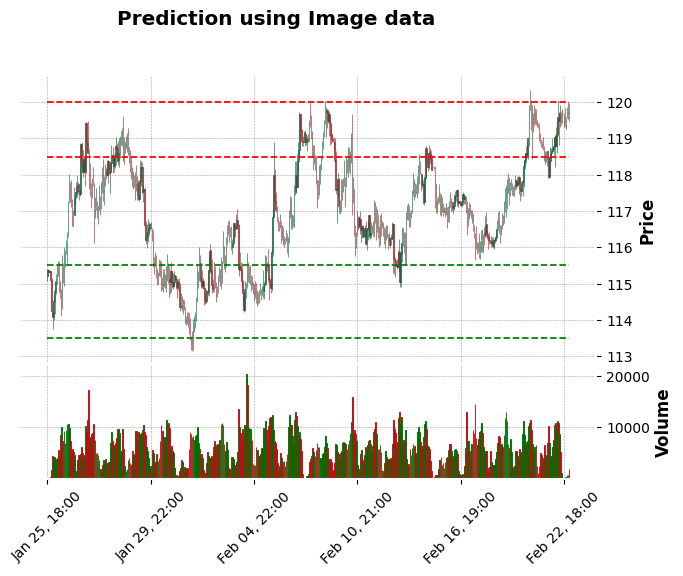

{'support_high': 115.5, 'support_low': 113.5, 'resistance_high': 120.0, 'resistance_low': 118.5}


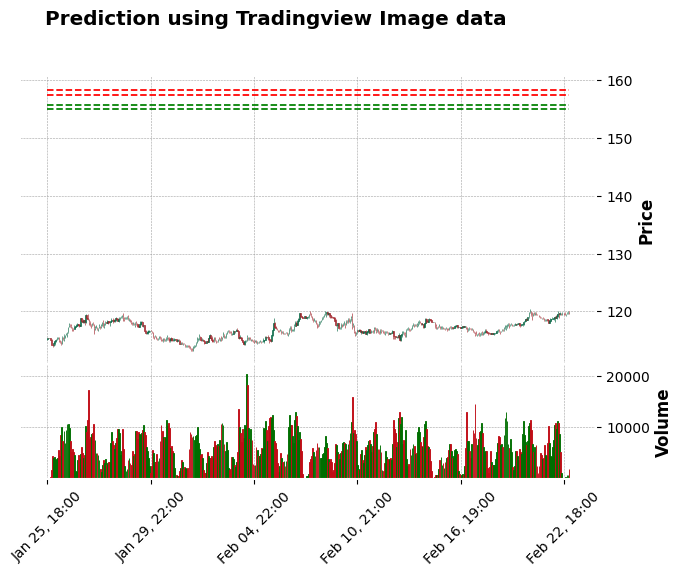

{'support_high': 155.8, 'support_low': 155.0, 'resistance_high': 158.4, 'resistance_low': 157.4}


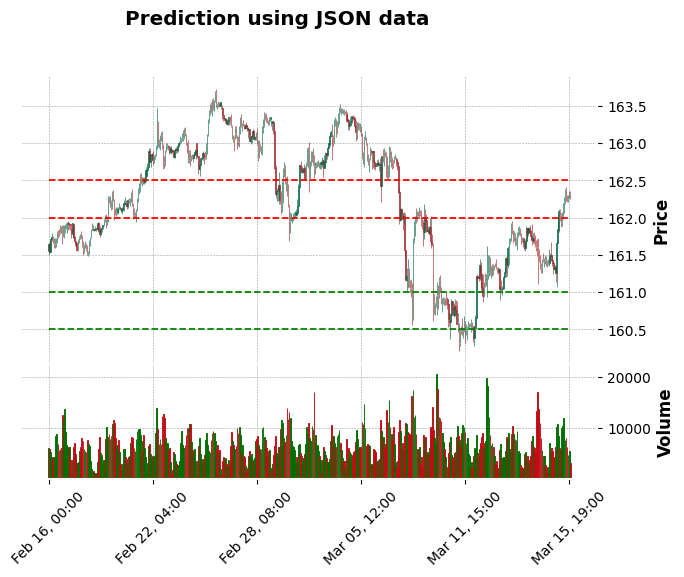

{'support_high': 161.0, 'support_low': 160.5, 'resistance_high': 162.5, 'resistance_low': 162.0}


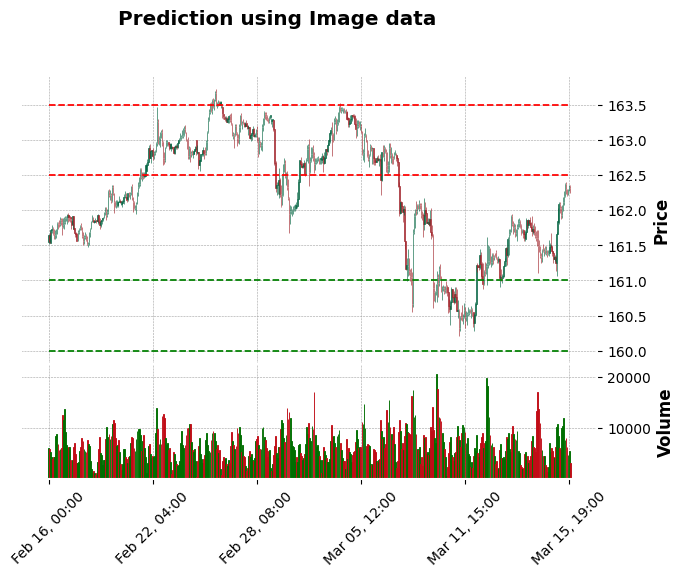

{'support_high': 161.0, 'support_low': 160.0, 'resistance_high': 163.5, 'resistance_low': 162.5}


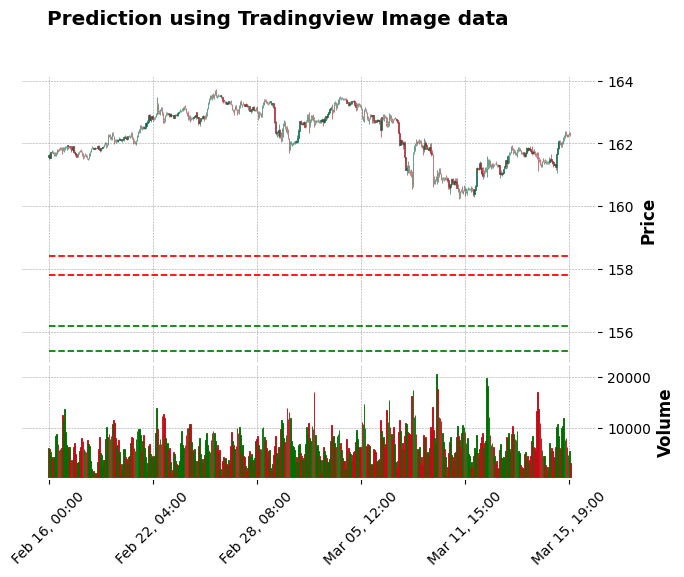

{'support_high': 156.2, 'support_low': 155.4, 'resistance_high': 158.4, 'resistance_low': 157.8}


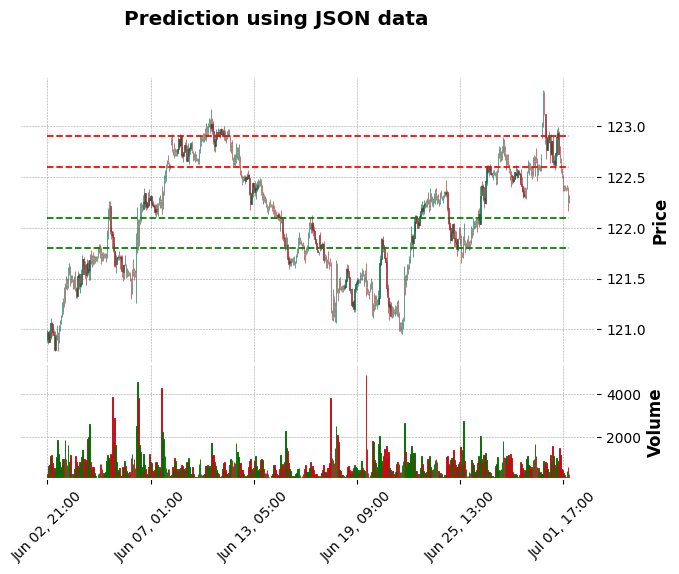

{'support_high': 122.1, 'support_low': 121.8, 'resistance_high': 122.9, 'resistance_low': 122.6}


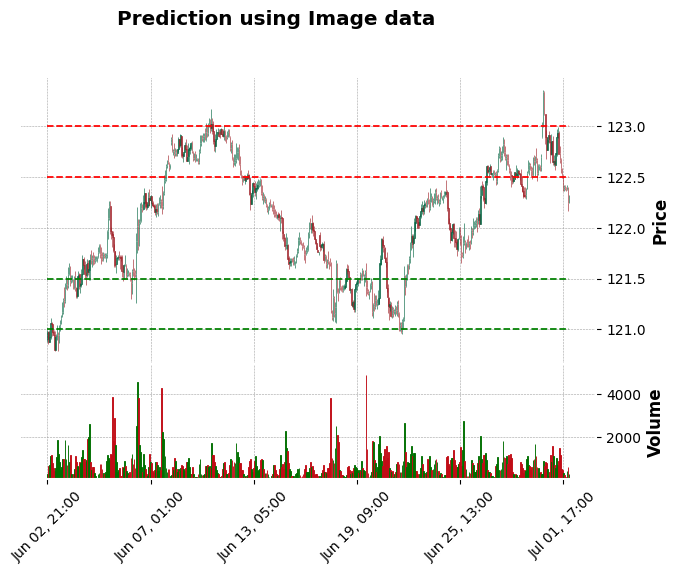

{'support_high': 121.5, 'support_low': 121.0, 'resistance_high': 123.0, 'resistance_low': 122.5}


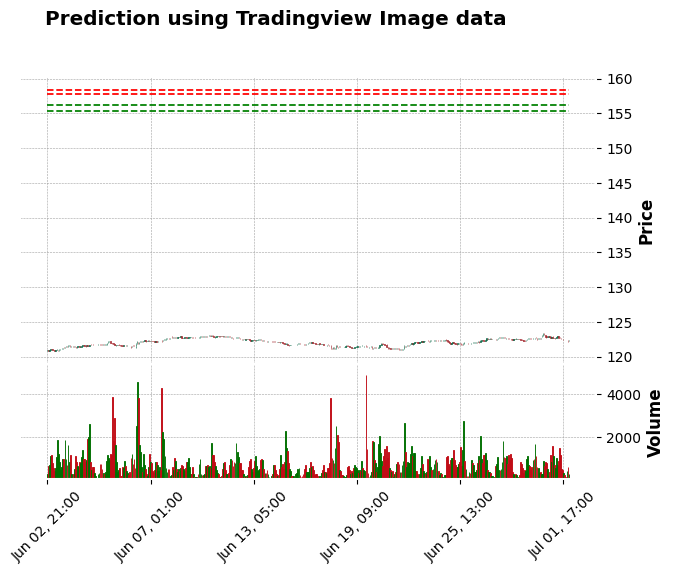

{'support_high': 156.2, 'support_low': 155.4, 'resistance_high': 158.4, 'resistance_low': 157.8}


In [16]:
for end_date in end_date_samples:
    run_single_sample(end_date)

# Conclusion

It seems that the LLM predicts the S&R bands more accurately when given the candlestick data in IMAGE format rather than JSON format